In [127]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

np.seed = 1
torch.manual_seed(1)

training_set_size = 15
validation_set_size = 100

interval = 2

epsilon_noise = 0.1

min_nodes = 4
max_nodes = 31
steps_nodes = 5
step_size_nodes = int(np.ceil( (max_nodes - min_nodes) / (steps_nodes - 1) ))


min_epoch = 100
max_epoch = 700
steps_epoch = 5
step_size_epoch = int(np.ceil( (max_epoch - min_epoch) / (steps_epoch - 1) ))


In [128]:
# class SinApproximator(nn.Module):
    
#     def __init__(self, nodes=10):

#         super(SinApproximator, self).__init__()
        
#         self.fc = nn.Linear(2, nodes)  # Input: x, sin(x), rand()
#         self.hidden = nn.ReLU()
#         self.out = nn.Linear(nodes, 1)  # Output: approximated sin(x)

#     def forward(self, x):
#         x = self.hidden(self.fc(x))
#         x = self.out(x)
#         return x

class SinApproximator(nn.Module):
    def __init__(self, nodes=10):
        super(SinApproximator, self).__init__()
        
        self.fc = nn.Linear(2, nodes)
        self.fc2 = nn.Linear(nodes, nodes)
        self.fc3 = nn.Linear(nodes, nodes)
        self.fc4 = nn.Linear(nodes, nodes)
        self.fc5 = nn.Linear(nodes, nodes)
        # self.fc6 = nn.Linear(nodes, nodes)
        self.out = nn.Linear(nodes, 1)
        
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.relu(self.fc5(x))
        # x = self.relu(self.fc6(x))
        x = self.out(x)
        return x


In [129]:

def generate_data(training_set_size, validation_set_size, how, epsilon_noise):
    # Generate total number of samples
    total_samples = training_set_size + validation_set_size
    
    if how == "linspace":
        x = np.linspace(-interval * np.pi, interval * np.pi, total_samples)
    elif how == "random":
        x = np.random.uniform(-interval*np.pi, interval*np.pi, total_samples)
    
    # Generate noise features and target values
    noise_x = np.random.rand(total_samples)
    y = np.sin(x) + np.random.normal(loc=0.0, scale=epsilon_noise, size=x.shape)
    
    # Combine features
    X = np.vstack([x, noise_x]).T
    
    # Split the data
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, 
        train_size=training_set_size,
        random_state=42
    )
    
    # Convert to PyTorch tensors
    return (torch.tensor(X_train, dtype=torch.float32),
            torch.tensor(y_train, dtype=torch.float32).unsqueeze(1),
            torch.tensor(X_val, dtype=torch.float32),
            torch.tensor(y_val, dtype=torch.float32).unsqueeze(1))



In [130]:

def plot(fig, axes, x_values, training_X, training_y, validation, validation_y, predictions, weights_b, train_loss, val_loss, nodes, epoch_number, order):


    axes[0].plot(x_values, np.sin(x_values),   label="True sin(x)")
    axes[0].plot(training_X[:, 0], training_y, label="Training data", marker='o', linestyle='', color='blue')
    axes[0].plot(validation[:, 0], validation_y, label="Validation data", marker="o", color='green', linestyle='')
    
    axes[0].plot(x_values, predictions,        label="Predicted sin(x)", linestyle="dashed", color='pink')

    axes[0].set_title(f"SinApproximator: Nodes:{nodes} - Epoch:{epoch_number}")
    # axes[0].axvline(x=-2*np.pi, color='red', linestyle='--')
    # axes[0].axvline(x=2*np.pi, color='red', linestyle='--')

    axes[0].legend()

    axes[1].plot(weights_b, label=f"Sum of weights of the {nodes} neurons, second input", color="black")
    axes[1].set_title(f"Weights second neuron: epoch:{epoch_number} - nodes:{nodes} - order:{order}")
    axes[1].axhline(y=0, color='red', linestyle='--', label='weight=0')

    axes[1].legend()

    axes[2].plot(train_loss, label="Training loss", linestyle="dashed")
    axes[2].plot(val_loss, label="Validation loss", linestyle="dashed", color='green')
    axes[2].set_title(f"Loss for epoch:{epoch_number} - nodes:{nodes}")
    #axes[2].set_xscale('log', base=2)
    axes[2].set_yscale('log', base=2)
    axes[2].legend()

    # Adjust layout for better spacing
    plt.tight_layout()

    plt.show()


In [131]:

# Training function
def train(model, X, y, validation_set, validaiton_set_y, num_epochs, learning_rate=0.05, lambda_reg=0.5, order=2):
    criterion = nn.MSELoss()
    optimizer = optim.RAdam(model.parameters(), lr=learning_rate)

    weights_b = []

    losses_validation = []
    losses_train = []

    for _epoch_ in range(num_epochs):
        
        optimizer.zero_grad()
        outputs = model(X)

        # Training loss
        plain_train_loss = criterion(outputs, y)

        # Regularization on weights associated with random input
        reg_loss = 0
        
        if order ==0:
            norm_weights = 0 
        if order == 1:
            norm_weights = torch.sum(torch.abs(model.fc.weight[:, 1]))     
        if order ==2:
            norm_weights = torch.sum(model.fc.weight[:, 1]**2)            
       
        reg_loss = lambda_reg * norm_weights  

        total_training_loss = plain_train_loss + reg_loss

        # Validation loss
        with torch.no_grad():
            validation_predicted = model(torch.tensor(validation_set, dtype=torch.float32))
            loss_validation = criterion(validation_predicted, validaiton_set_y)
            #returnvalloss = loss_validation+reg_loss
            losses_validation.append(loss_validation.item()) 

        # # train loss
        # with torch.no_grad():
        #     train_predicted = model(torch.tensor(X, dtype=torch.float32))
        #     loss_train = criterion(train_predicted, torch.sin(X[:,0]))
        #     losses_train.append(loss_train.item()) 



        losses_train.append(total_training_loss.item())
        weights_b.append(np.sum(np.abs(model.fc.weight.data[:,0].numpy())))

        total_training_loss.backward()
        optimizer.step()


    
    return weights_b, losses_train, losses_validation, validation_predicted

/var/folders/cd/x29qw_lj0yzf26xq_q6rzr3r0000gn/T/ipykernel_86471/1629068027.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_predicted = model(torch.tensor(validation_set, dtype=torch.float32))


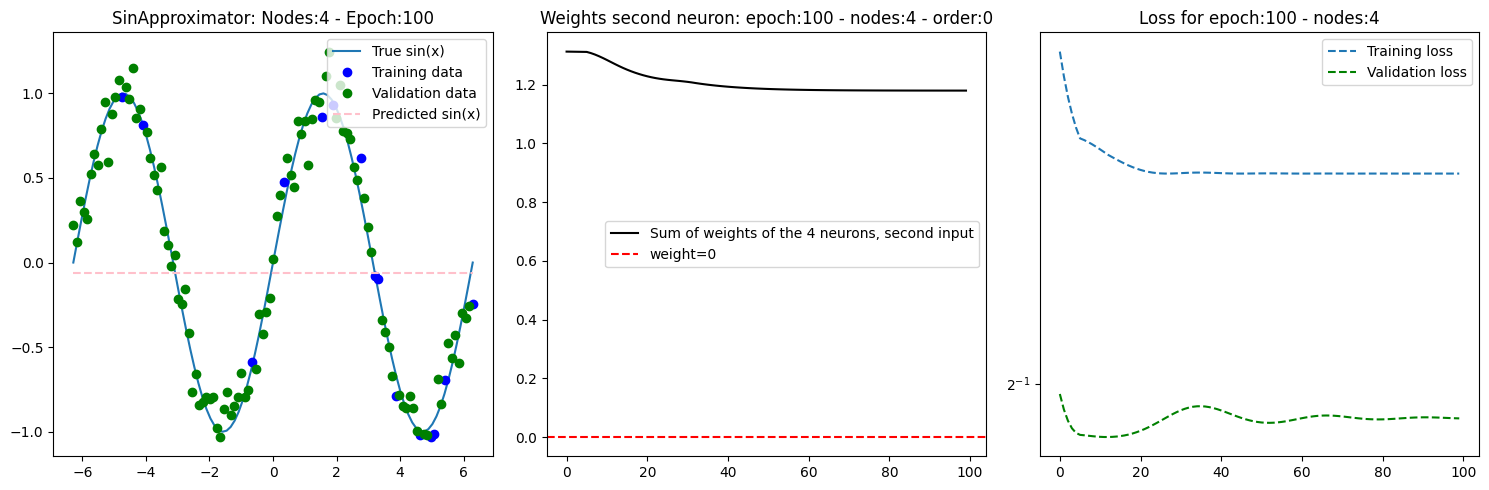

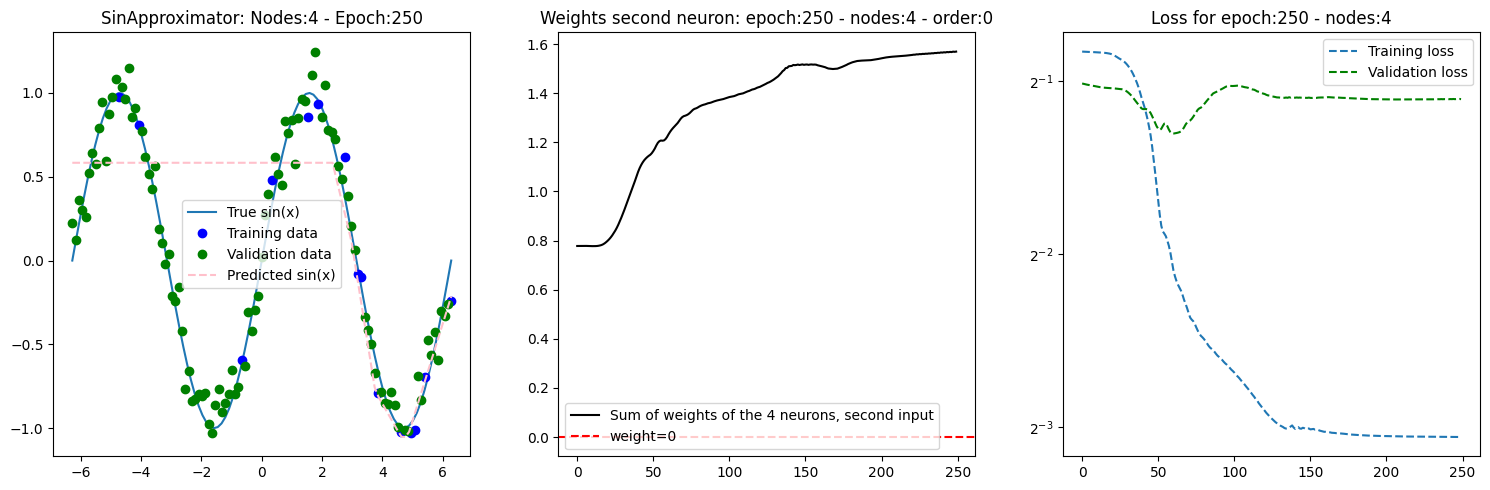

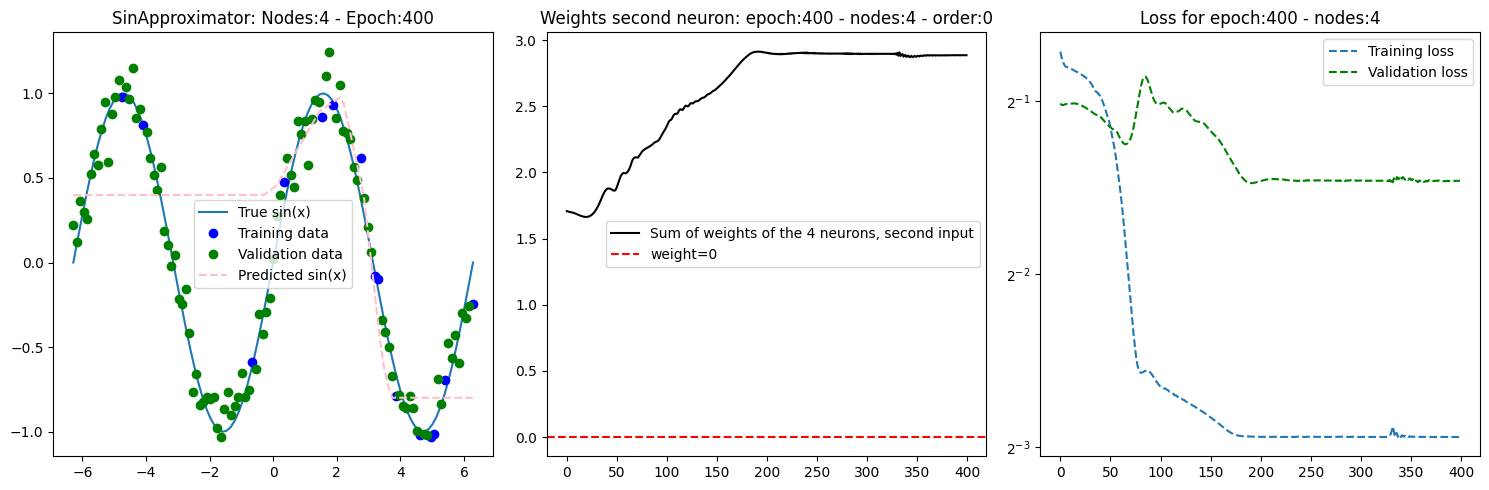

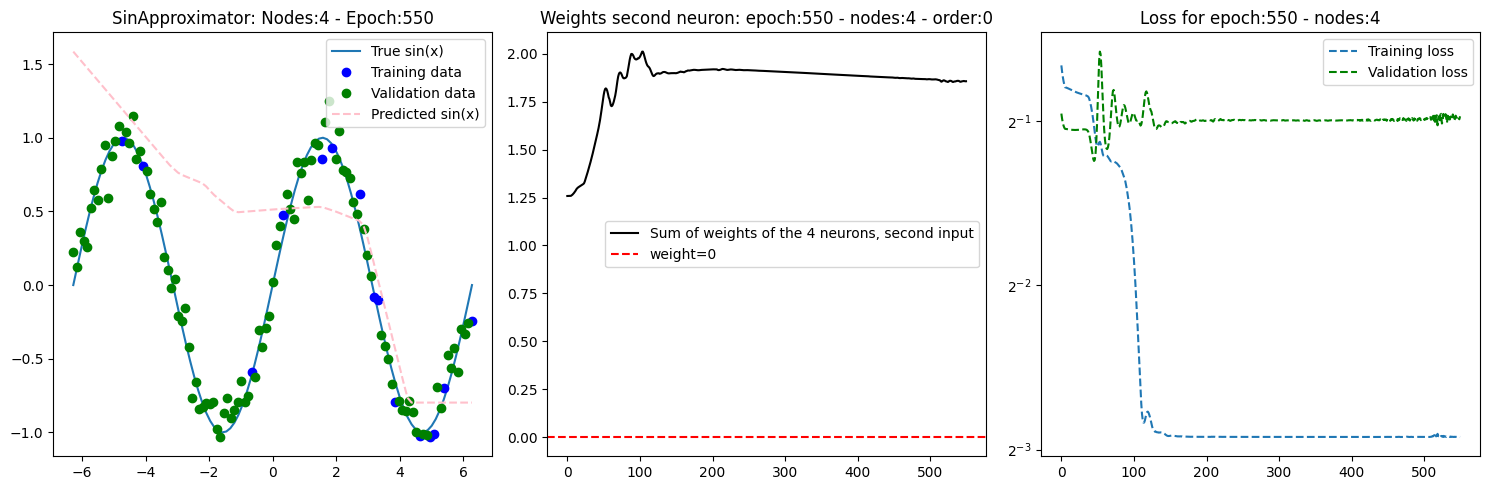

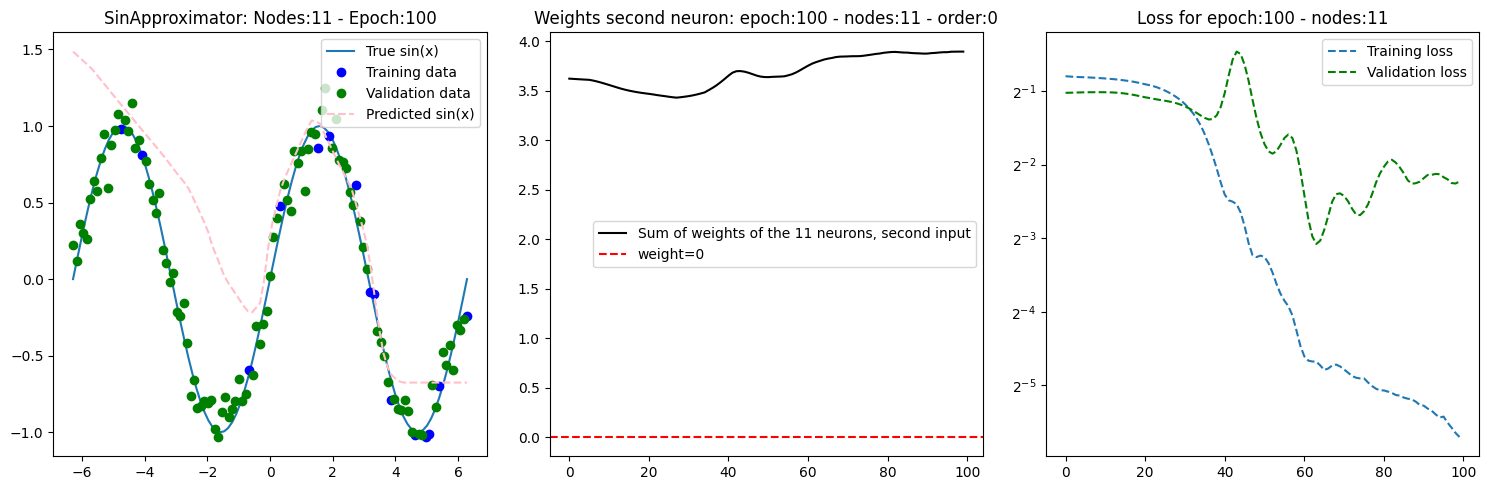

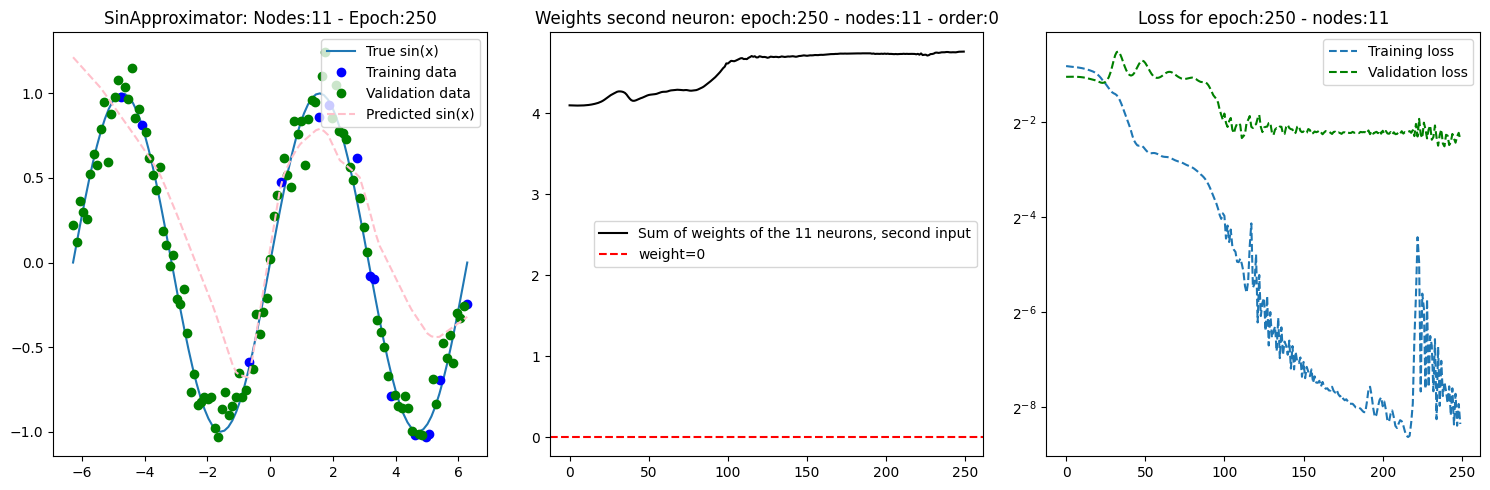

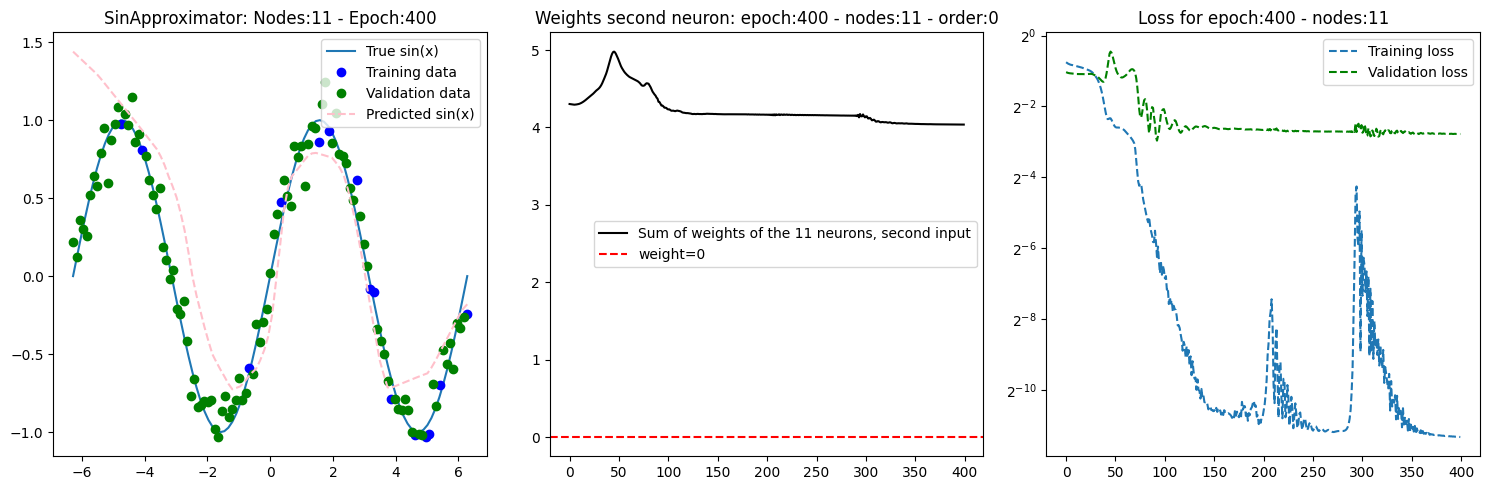

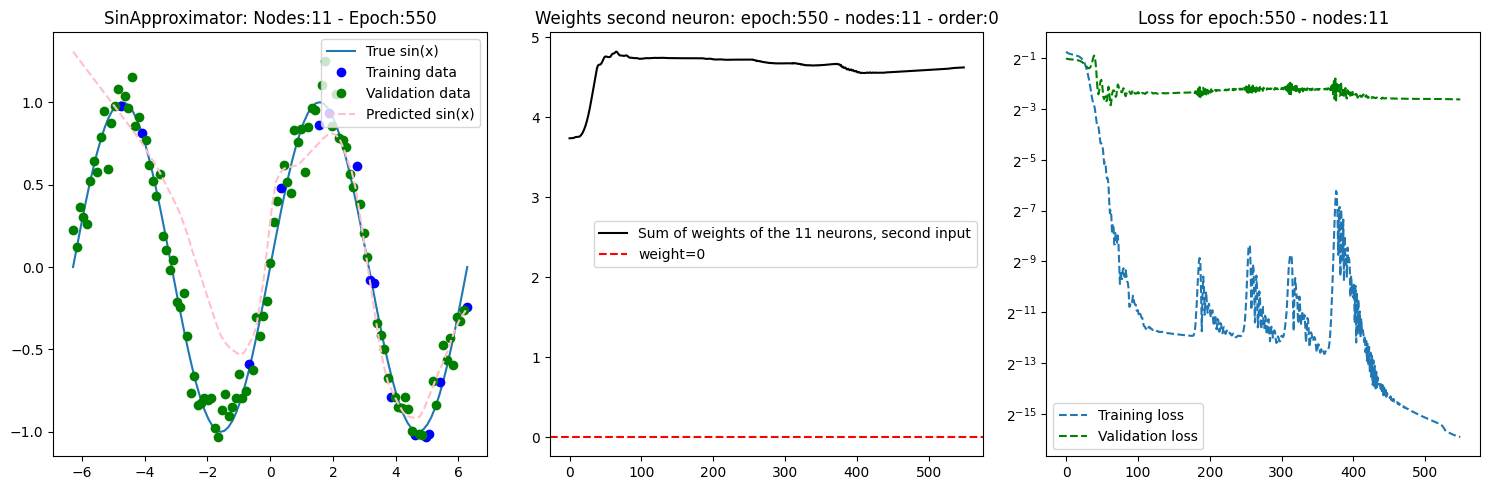

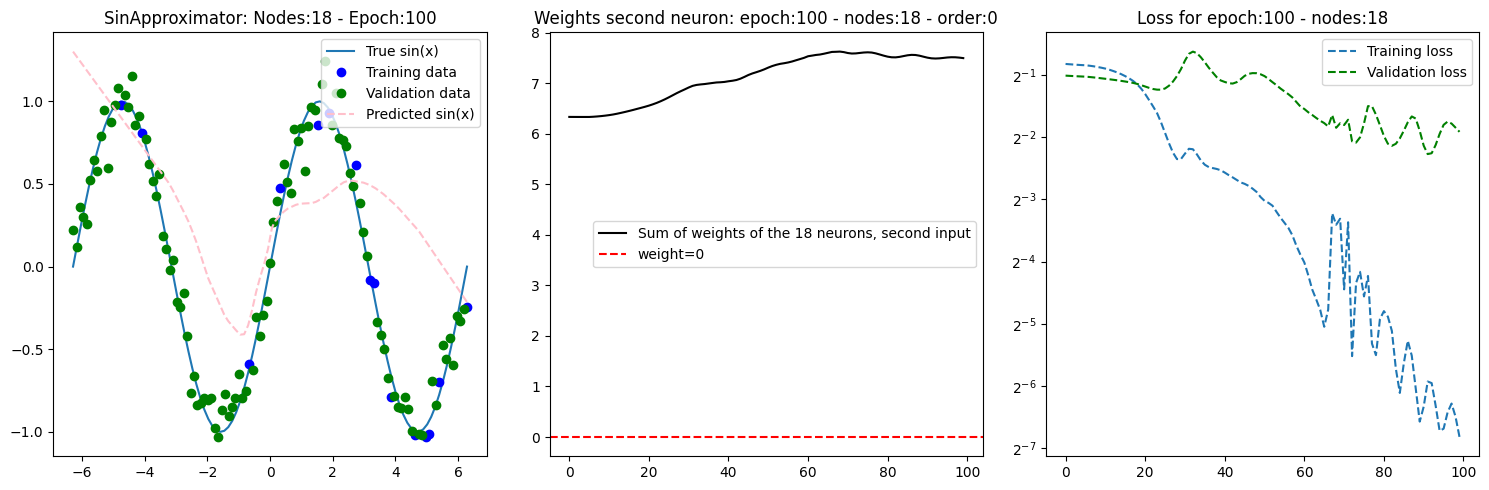

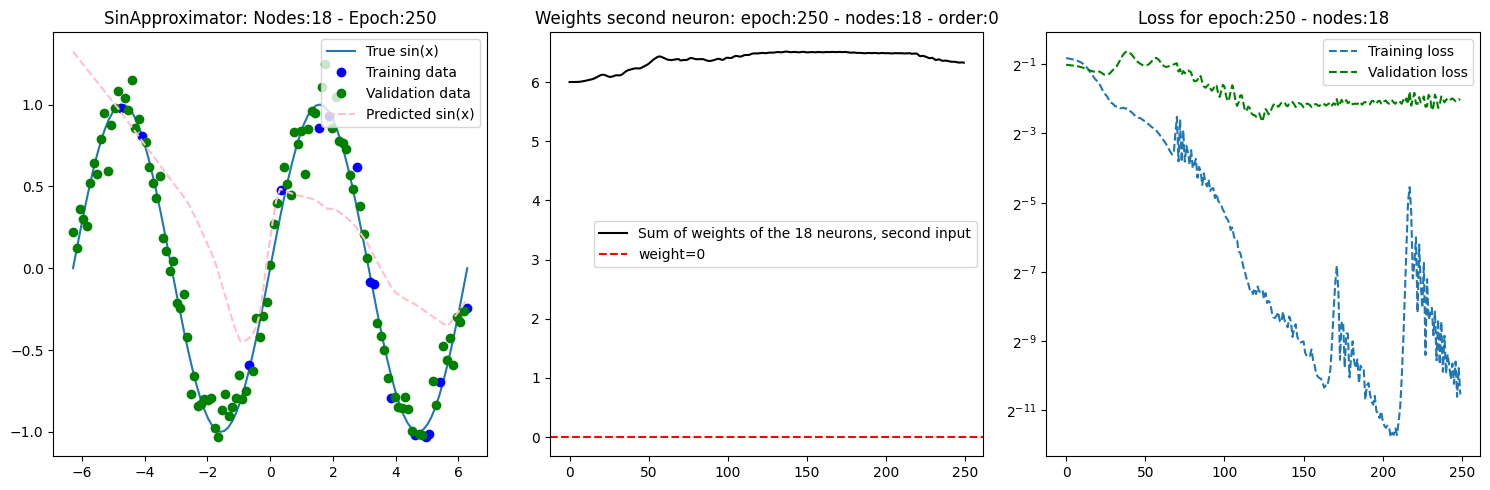

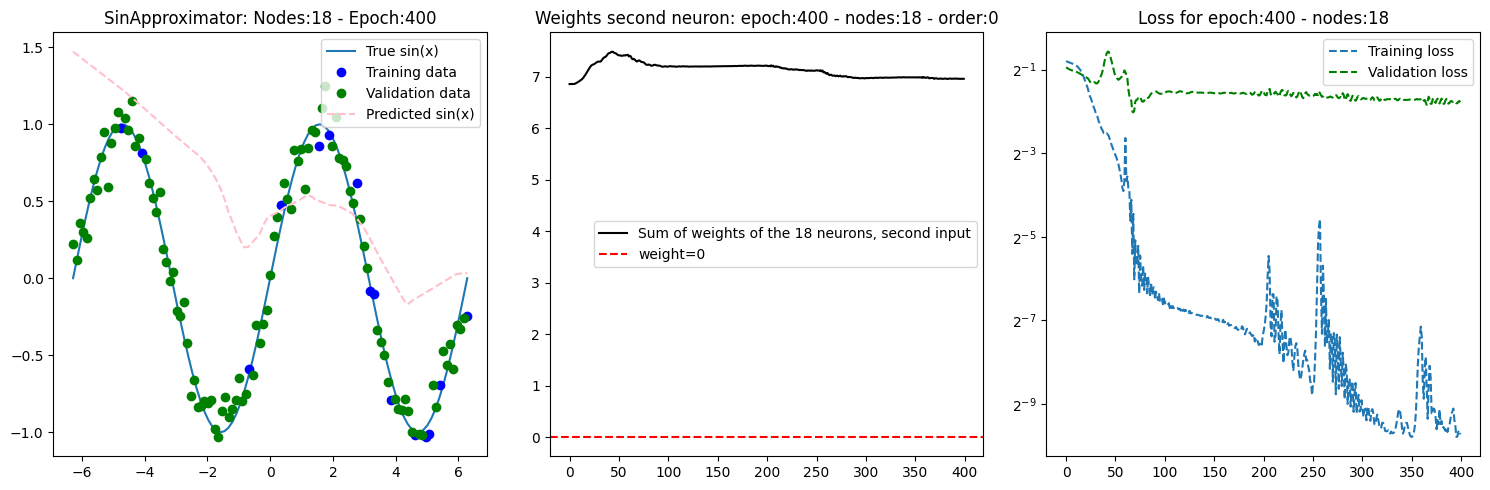

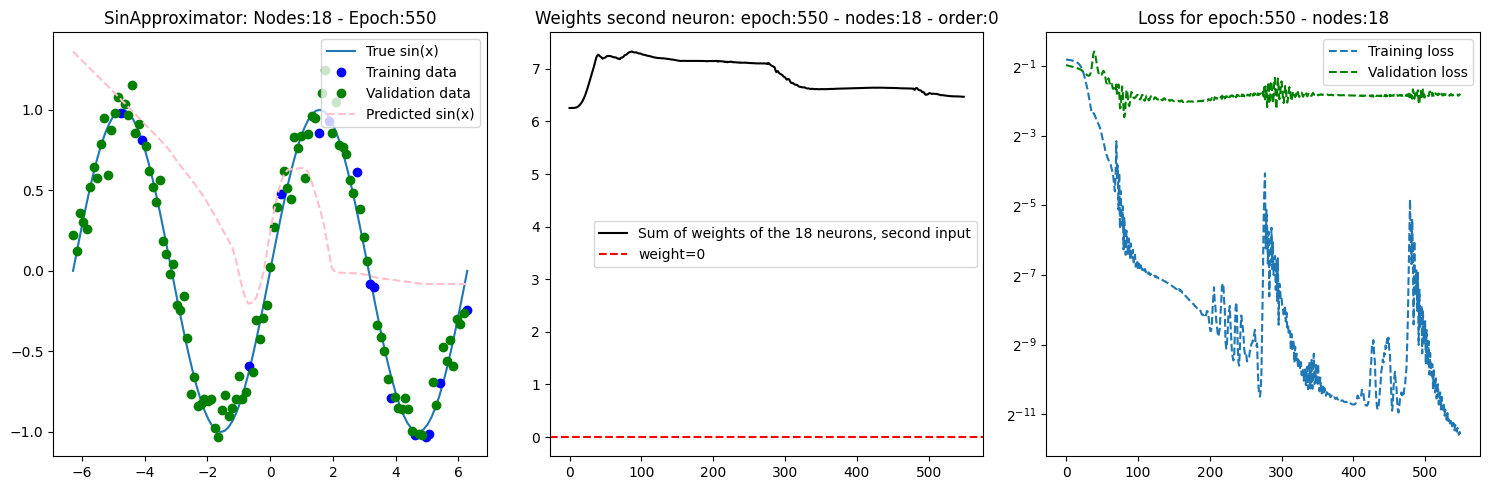

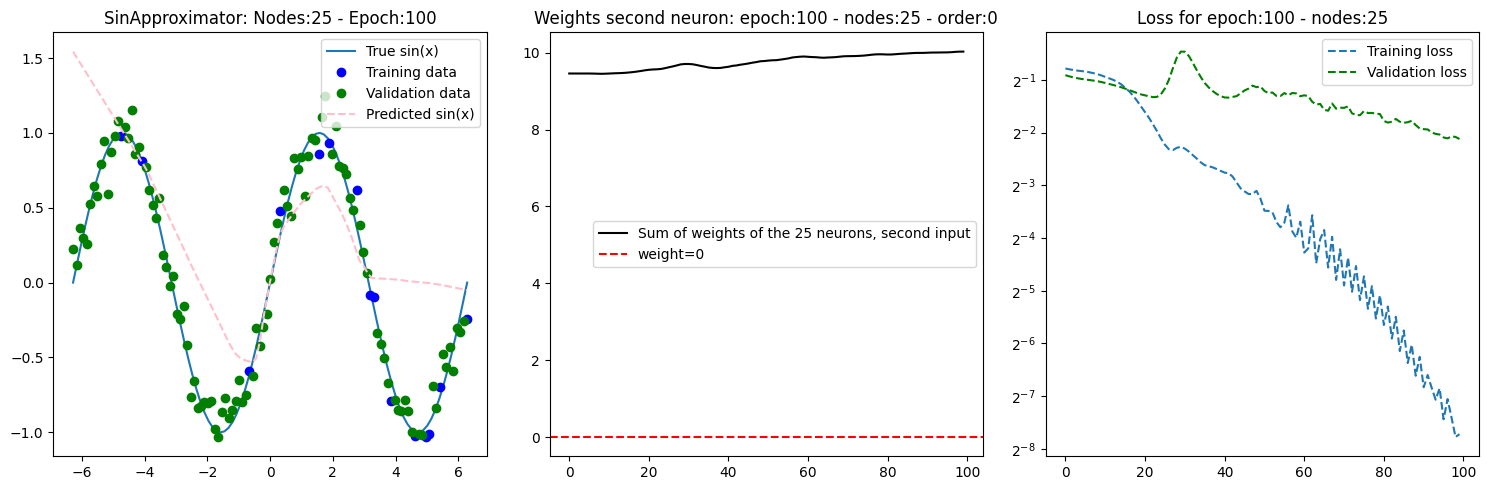

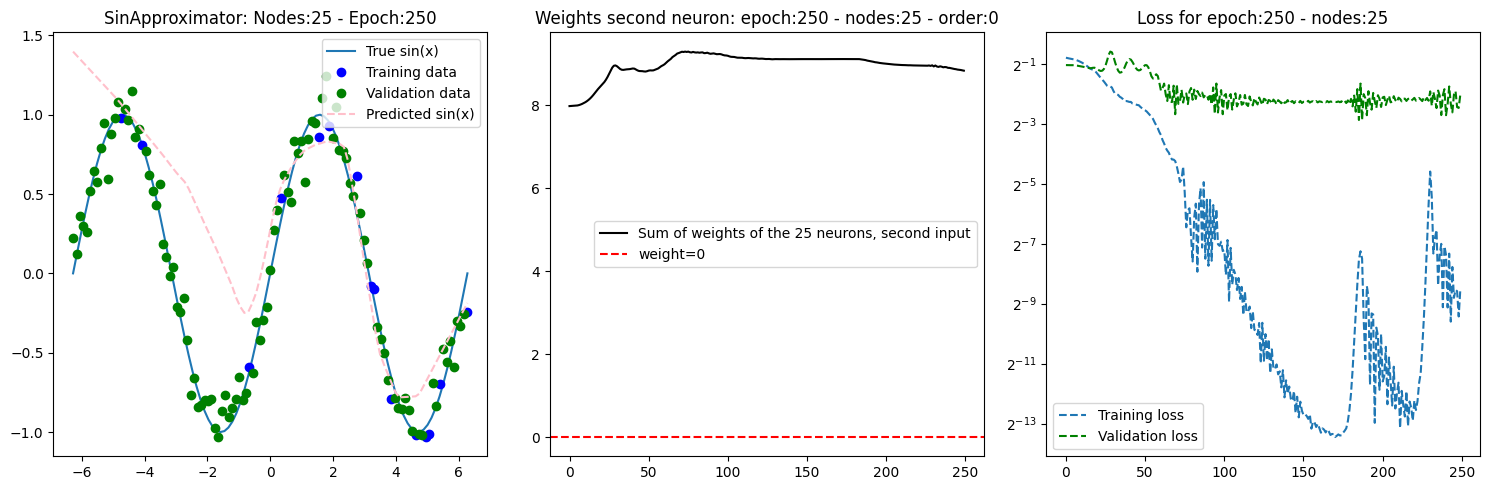

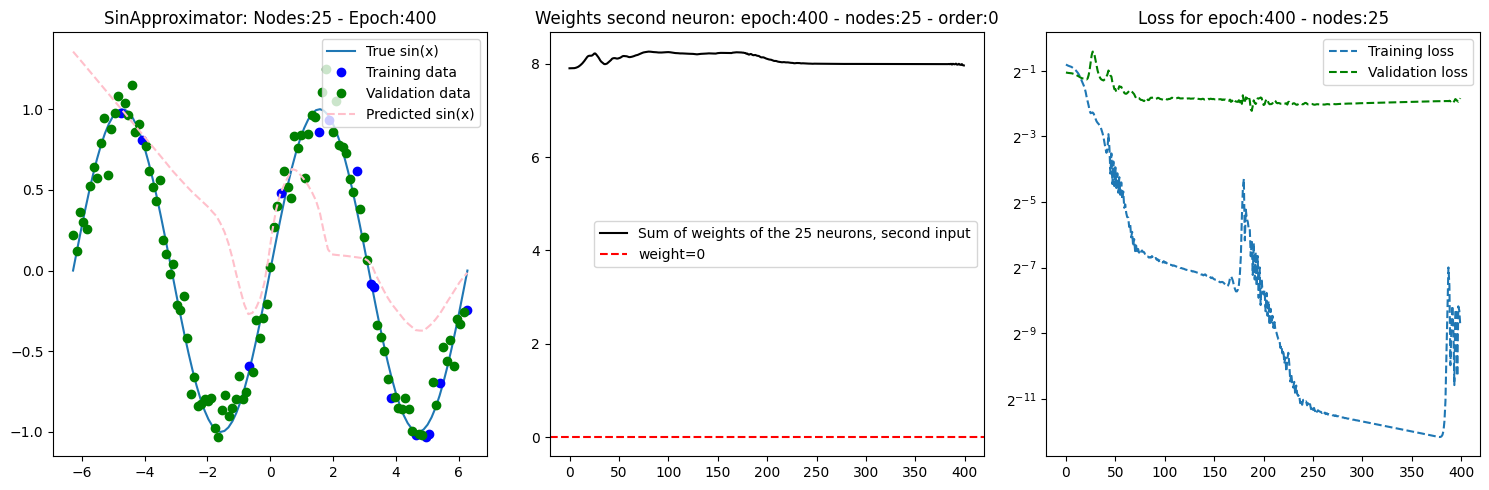

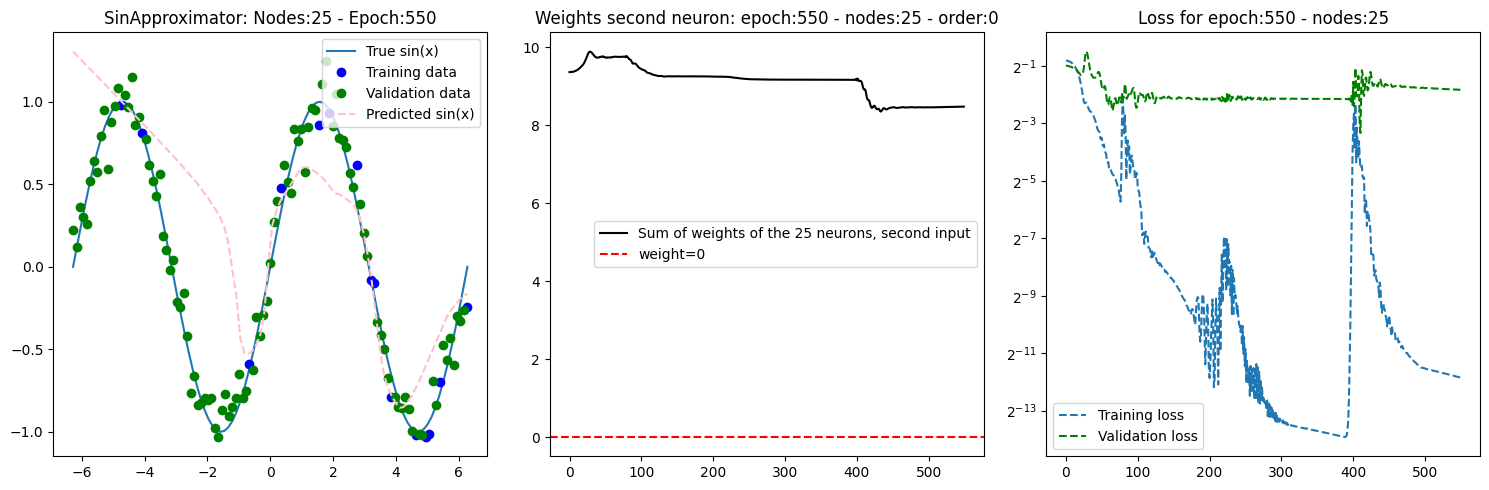

In [132]:
# let's sample values to plot 
x_values = np.linspace(-interval * np.pi, interval * np.pi, 100)
x_values_ = np.vstack([x_values, np.zeros_like(x_values)])

training_X, training_y, validation, validation_y = generate_data(training_set_size, validation_set_size,
                                                                  how="linspace", epsilon_noise=epsilon_noise)

for nodes in range(min_nodes, max_nodes, step_size_nodes):
    for epoch_number in range(min_epoch, max_epoch, step_size_epoch):
        for order in (0,): #,1,2):
                    
            model = SinApproximator(nodes=nodes)


            # Train the model
            weights_b, train_loss, val_loss, validation_predicted = train(model, training_X, training_y, validation, 
                                                                          validation_y, num_epochs=epoch_number, order=order)


            fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

            #validation_by_model = model(validation)

            with torch.no_grad():

                predictions = model(torch.tensor(x_values_.T, dtype=torch.float32)).numpy()

                # print(model.fc.weight[:, 1])
                # print(model.fc.weight[:, 0])
                plot(fig, axes, x_values, training_X, training_y, validation, validation_y, 
                     predictions, weights_b, train_loss, val_loss, nodes, epoch_number, order)



